![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor

In [4]:
dataTraining_remote = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
dataTesting_remote = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)


In [7]:
dataTraining = dataTraining_remote.copy()
dataTesting = dataTesting_remote.copy()

df_total = pd.concat([dataTraining,dataTesting])

le_state = preprocessing.LabelEncoder()
le_make = preprocessing.LabelEncoder()
le_model = preprocessing.LabelEncoder()

df_total["State"] = le_state.fit_transform(df_total["State"])
df_total["Make"] = le_make.fit_transform(df_total["Make"])
df_total["Model"] = le_model.fit_transform(df_total["Model"])

x = dataTraining[['Year', 'Mileage']].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
#x_scaled = scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=['Year', 'Mileage'])

dataTraining = pd.concat([dataTraining[['Price', 'State', 'Make', 'Model']], df_scaled], axis=1, join="inner")

dataTraining["State"] = le_state.transform(dataTraining["State"])
dataTraining["Make"] = le_make.transform(dataTraining["Make"])
dataTraining["Model"] = le_model.transform(dataTraining["Model"])

# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
X = dataTraining.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1111)


## Random Forest

Best n_estimators value = 500, mse = 14210605.158193737


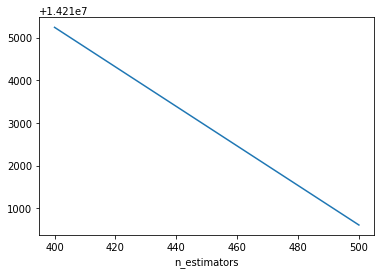

In [13]:
# Definir función para graficar el mse vs parametro
def plot_mse(param_Range, scores, param_name = "N"):
    plt.plot(param_Range, scores)
    plt.xlabel(param_name)
    vals_dict = {p:v for p,v in zip(param_Range, scores)}
    worst_to_best = sorted(vals_dict, key = lambda x: vals_dict[x])
    print(f"Best {param_name} value = {worst_to_best[0]}, mse = {min(scores)}")

    
# Definir valores posibles de parámetros
estimators = range(400, 501, 100)

# Estimar el mejor valor de n_estimators
estimators_accuracy_scores = []
for n in estimators:
    clf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    estimators_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean() *(-1))

plot_mse(estimators, estimators_accuracy_scores, param_name = "n_estimators")

Best depths value = 18, mse = 12874602.491558399


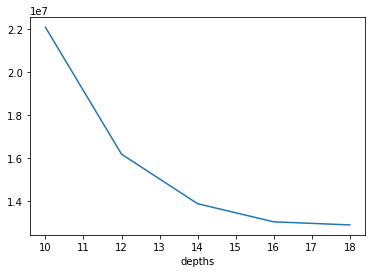

In [10]:
depths = range(10, 20, 2)

# Estimar el mejor valor de n_estimators
estimators_accuracy_scores = []
for n in depths:
    clf = RandomForestRegressor(n_estimators = 400, max_depth=n, random_state=1, n_jobs=-1)
    estimators_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean() *(-1))
    
plot_mse(depths, estimators_accuracy_scores, param_name = "depths")

Best features value = 4, mse = 12694361.740721436


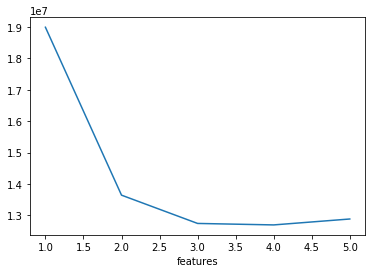

In [12]:
n_features = X.shape[1]
features = range(1, n_features+1)

# Estimar el mejor valor de n_estimators
estimators_accuracy_scores = []
for n in features:
    clf = RandomForestRegressor(n_estimators = 400, max_depth=18,  max_features = n ,random_state=1, n_jobs=-1)
    estimators_accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean() *(-1))

plot_mse(features, estimators_accuracy_scores, param_name = "features")

In [37]:
# Definición de modelo Random Forest para un problema de regresion
modelo_rf = RandomForestRegressor( n_estimators = 400, max_depth=18,  max_features = 4 , n_jobs=-1)

modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

metrics.mean_squared_error(y_test, y_pred)

12732534.800713575

In [38]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))


3568.2677591113556

## Predict test

In [21]:
dataTesting = dataTesting_remote.copy()
x_test = dataTesting[['Year', 'Mileage']].values #returns a numpy array
x_encoding_test = min_max_scaler.transform(x_test)
df_encoding_test = pd.DataFrame(x_encoding_test, columns=['Year', 'Mileage'])

dataTesting = pd.concat([dataTesting[['State', 'Make', 'Model']], df_encoding_test], axis=1, join="inner")
dataTesting["State"] = le_state.transform(dataTesting["State"])
dataTesting["Make"] = le_make.transform(dataTesting["Make"])
dataTesting["Model"] = le_model.transform(dataTesting["Model"])

y_pred_test = modelo_rf.predict(dataTesting)
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.rename(columns={0:'Price'},inplace = True)
y_pred_test.to_csv('submission.csv', index_label='ID')

In [39]:
from pickle import dump
import pickle
# save the scaler
dump(min_max_scaler, open('scaler.pkl', 'wb'))
              
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(modelo_rf, open(filename, 'wb'))


In [40]:
dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

loaded_minmax = pickle.load(open('scaler.pkl', 'rb'))

x_test = dataTesting[['Year', 'Mileage']].values #returns a numpy array
x_encoding_test = loaded_minmax.transform(x_test)
df_encoding_test = pd.DataFrame(x_encoding_test, columns=['Year', 'Mileage'])

dataTesting = pd.concat([dataTesting[['State', 'Make', 'Model']], df_encoding_test], axis=1, join="inner")
dataTesting["State"] = le_state.transform(dataTesting["State"])
dataTesting["Make"] = le_make.transform(dataTesting["Make"])
dataTesting["Model"] = le_model.transform(dataTesting["Model"])

loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
y_pred_test = loaded_model.predict(dataTesting)

y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.rename(columns={0:'Price'},inplace = True)
y_pred_test.to_csv('submission.csv', index_label='ID')

In [41]:
y_pred_test

,Price
0,20789.706442
1,36943.107879
2,24103.576521
3,9652.100982
4,31167.915028
...,...
99995,20458.645127
99996,39706.898799
99997,23620.456661
99998,16905.953166
